# Fourth Down Analysis

#### Import Packages

In [1]:
import math
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import seaborn as sns
import utils
import warnings
warnings.filterwarnings('ignore')

### Load data and process dataframes

In [6]:
pdata = pd.read_csv('data/fourth_down.csv.gz', index_col=0)

In [7]:
## subset onto useful data
play_types = ['punt', 'field_goal', 'run', 'pass']
cdf = pdata[(pdata['play_type'].isin(play_types)) & (~pdata['go_boost'].isna())]
# assign new category for team and season
cdf['team_season'] = cdf['posteam'].astype('str') + '__' + cdf['season'].astype('str')
## annotate dataframe
cdf['should_go'] = [1 if (x > 1) else -1 if (x < -1) else 0 for x in cdf['go_boost']]
cdf['go_group'] = [utils.go_group(x) for x in cdf['go_boost']]
cdf['go_numcat'] = [utils.roundboost(x) for x in cdf['go_boost']]
# assign go_cat from the assigned go to match our names
cdf['go_cat'] = [-1 if x == 0 else 1 for x in cdf['go']]
cdf['agree'] = (cdf['go_cat'] == cdf['should_go'])
## get subset of dataframe in regular season
rdf = cdf[cdf['season_type'] == 'REG']

In [8]:
# Titans dataframe where they are team possessing the ball
tdf = pdata[pdata['posteam']=='TEN']
# Subset Titans dataframe to exclude fourth quarter and overtime (stored as 5)
etdf = tdf[~tdf['qtr'].isin([4, 5])]

### Fourth down rates by season

#### Total

In [9]:
rdf[['season', 'go']].groupby('season').mean()

,go
season,
2014,11.710986
2015,11.977642
2016,12.214984
2017,12.166405
2018,14.530635
2019,15.939227
2020,18.912530
2021,20.513506
2022,18.654196


#### Under 3 yards

In [10]:
srdf = rdf[rdf['ydstogo']<=3]

In [11]:
srdf[['season', 'go']].groupby('season').mean()

,go
season,
2014,24.522613
2015,24.974824
2016,28.751312
2017,26.736842
2018,35.982340
2019,39.408284
2020,45.206972
2021,47.206166
2022,44.066237


#### Under 3 yards

In [12]:
srdf = rdf[rdf['ydstogo']<=2]

In [13]:
srdf[['season', 'go']].groupby('season').mean()

,go
season,
2014,29.855072
2015,31.075110
2016,33.430233
2017,32.634731
2018,44.622793
2019,48.322148
2020,54.385965
2021,57.880795
2022,51.388889


#### Under 1 yards

In [14]:
srdf = rdf[rdf['ydstogo']==1]

In [15]:
srdf[['season', 'go']].groupby('season').mean()

,go
season,
2014,41.645244
2015,42.741935
2016,42.788462
2017,44.125326
2018,57.029178
2019,58.591549
2020,66.276347
2021,69.955157
2022,62.970711


In [16]:
a = []
for i in np.arange(1,4):
    srdf = rdf[rdf['ydstogo']<=i]
    a.append(srdf[['season', 'go']].groupby('season').mean().set_axis([str(i)], axis=1).T)
    

In [17]:
fdf = pd.concat(a).unstack().reset_index().set_axis(['season', 'yards', 'percent'], axis=1)

In [18]:
x1 = fdf[fdf['yards']=='1']
x2 = fdf[fdf['yards']=='2']
x3 = fdf[fdf['yards']=='3']

In [20]:
seasons = range(2014,2024)

[Text(0, 20.0, '20%'),
 Text(0, 30.0, '30%'),
 Text(0, 40.0, '40%'),
 Text(0, 50.0, '50%'),
 Text(0, 60.0, '60%'),
 Text(0, 70.0, '70%'),
 Text(0, 80.0, '80%')]

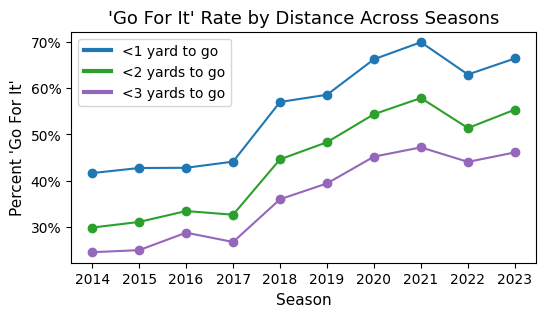

In [21]:
fig,ax = plt.subplots(figsize=(6,3))
ax.scatter(x1['season'], x1['percent'], zorder=1, color='tab:blue')
ax.plot(x1['season'], x1['percent'], zorder=2, color='tab:blue')

ax.scatter(x2['season'], x2['percent'], zorder=1, color='tab:green')
ax.plot(x2['season'], x2['percent'], zorder=2, color='tab:green')

# plt.scatter(x3['season'], x3['percent'], zorder=1, color='tab:purple', s=100, edgecolor='black', linewidth=1)
ax.scatter(x3['season'], x3['percent'], zorder=1, color='tab:purple')
ax.plot(x3['season'], x3['percent'], zorder=2, color='tab:purple')

ax.set_xticks(seasons)
ax.set_ylabel("""Percent 'Go For It'""", fontsize=11)
ax.set_xlabel('Season', fontsize=11)
ax.set_title("""'Go For It' Rate by Distance Across Seasons""", fontsize=13)

legend_elements = [
    Line2D([0], [0], color='tab:blue', lw=3, label='<1 yard to go'),
    Line2D([0], [0], color='tab:green', lw=3, label='<2 yards to go'),
    Line2D([0], [0], color='tab:purple', lw=3, label='<3 yards to go')
]

ax.legend(handles=legend_elements, loc='best')
yticks = ax.get_yticks()
ax.set_yticklabels([f'{int(y)}%' for y in yticks])

### Team agreement

In [22]:
## subset onto data where there is a recommendation go or kick (i.e. should go does not equal 0)
adf = rdf[rdf['should_go'] != 0]
mdf = utils.mean_df(adf)
mdf.sort_values('agree').tail(5)

,go,go_boost,agree,season,team
team_season,,,,,
ATL__2022,17.741935,-1.495742,0.903226,2022,ATL
PHI__2023,22.222222,-1.490412,0.904762,2023,PHI
TEN__2022,12.000000,-2.317837,0.906667,2022,TEN
CAR__2023,23.170732,-1.140058,0.914634,2023,CAR
SF__2023,7.500000,-1.584971,0.950000,2023,SF


In [23]:
omdf = mdf[mdf['team']!='TEN'] ## all non Titans teams
tmdf = mdf[mdf['team']=='TEN'] ## all Titans teams

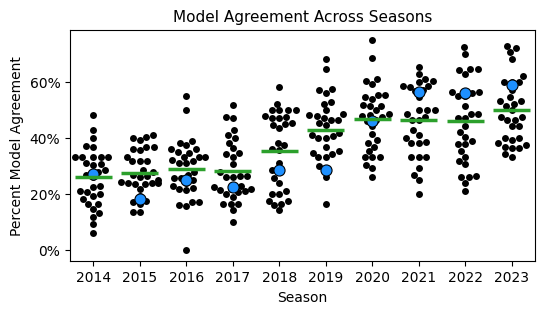

In [30]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.swarmplot(data=omdf, x='season', y='agree', color='black', ax=ax)
sns.swarmplot(data=tmdf, x='season', y='agree', color='dodgerblue', ax=ax,
             size=8, linewidth=0.8, edgecolor='black')

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'tab:green', 'ls': '-', 'lw': 2.5},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="season",
            y="agree",
            data=mdf,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

ax.set_ylabel('Percent Model Agreement')
ax.set_xlabel('Season')
ax.set_title('Model Agreement Across Seasons', fontsize=11)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))


### Team agreement (go decisions)

In [25]:
## subset onto data where there is a recommendation go or kick
adf = rdf[rdf['should_go'].isin([1,2])]
mdf = utils.mean_df(adf)
mdf.sort_values('agree').tail(5)

,go,go_boost,agree,season,team
team_season,,,,,
ARI__2023,70.833333,3.204083,0.708333,2023,ARI
PHI__2023,72.222222,2.935638,0.722222,2023,PHI
GB__2022,72.413793,4.601862,0.724138,2022,GB
CAR__2023,73.076923,3.593550,0.730769,2023,CAR
GB__2020,75.000000,4.573572,0.750000,2020,GB


In [26]:
omdf = mdf[mdf['team']!='TEN']
tmdf = mdf[mdf['team']=='TEN']

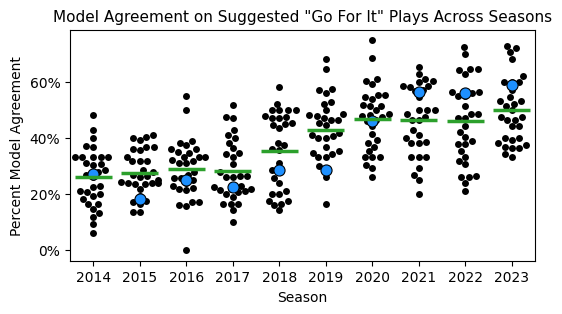

In [31]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.swarmplot(data=omdf, x='season', y='agree', color='black', ax=ax)
sns.swarmplot(data=tmdf, x='season', y='agree', color='dodgerblue', ax=ax,
             size=8, linewidth=0.8, edgecolor='black')

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'tab:green', 'ls': '-', 'lw': 2.5},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="season",
            y="agree",
            data=mdf,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

ax.set_ylabel('Percent Model Agreement')
ax.set_xlabel('Season')
ax.set_title('Model Agreement on Suggested "Go For It" Plays Across Seasons', fontsize=11)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))


### Aggressiveness in neutral decisions

In [32]:
## subset onto data where there is a recommendation go or kick
adf = rdf[rdf['should_go'].isin([0])]
mdf = utils.mean_df(adf)
mdf.sort_values('go').tail(5)

,go,go_boost,agree,season,team
team_season,,,,,
CAR__2021,35.135135,-0.002198,0.0,2021,CAR
GB__2017,35.294118,-0.132182,0.0,2017,GB
CLE__2022,35.714286,-0.079478,0.0,2022,CLE
DET__2023,36.363636,-0.055849,0.0,2023,DET
CAR__2023,38.666667,0.038125,0.0,2023,CAR


In [33]:
mmdf = mdf.sort_values('go', ascending=False).reset_index().head(5)
mmdf['Go Percent'] = round(mmdf['go'],2).astype('str') + '%'
mmdf['Go'] = mmdf['go']/100

Text(0.5, 1.0, 'Top 5 Teams by Go Percentage in Neutral Situations')

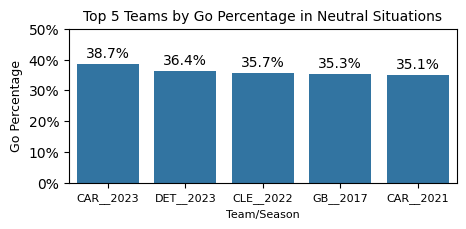

In [34]:
fig, ax = plt.subplots(figsize=(5,2))
sns.barplot(data=mmdf, x='team_season', y='Go',ax=ax)
ax.set_ylim(0,0.5)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

for index, row in mmdf.iterrows():
    plt.text(index, row['Go'] + 0.02, str(round(100*row['Go'],1)) + '%', color='black', ha='center')
    
ax.set_ylabel('Go Percentage', fontsize=9)
ax.set_xlabel('Team/Season', fontsize=8)
ax.set_title('Top 5 Teams by Go Percentage in Neutral Situations', fontsize=10)


### Titans fourth down to analyze

In [35]:
ctdf = cdf[cdf['posteam']=='TEN']

In [36]:
bplays =ctdf[ctdf['agree']==0].sort_values('go_boost', ascending=False)

### Colts 2021 fourth down

In [37]:
play = bplays.head(1)

In [38]:
play

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,go_wp,punt_wp,fg_wp,go,team_season,should_go,go_group,go_numcat,go_cat,agree
30235,3975,2021_08_TEN_IND,2021103106,IND,TEN,REG,8,TEN,away,IND,...,0.475358,0.359493,0.244801,0.0,TEN__2021,1,definitely_go,12,-1,False


In [39]:
play['go_boost'].values[0]

11.5864893612111

In [40]:
utils.play_summary(play)

'2021 (week 8): TEN (24) at IND (24). 01:39 left in the 4th Quarter. 4th down and 6 at IND 45. WP: 0.51 -> 0.45'

In [41]:
play['desc'].values

array(['(1:39) 6-B.Kern punts 37 yards to IND 8, Center-46-M.Cox, fair catch by 21-N.Hines.'],
      dtype=object)

### Ravens Playoff

In [42]:
play = bplays.head(2).tail(1)

In [43]:
play['go_boost'].values[0]

7.9949071287832

In [44]:
utils.play_summary(play)

'2020 (week 18): BAL (17) at TEN (13). 10:06 left in the 4th Quarter. 4th down and 2 at BAL 40. WP: 0.35 -> 0.31'

In [45]:
play['desc'].values

array(['(10:06) 6-B.Kern punts 25 yards to BAL 15, Center-47-M.Overton, fair catch by 13-D.Duvernay.'],
      dtype=object)

### Worst postseason decisions per model

In [46]:
ppp = cdf[(cdf['go']==0) & (cdf['season_type']=='POST')].sort_values('go_boost', ascending=False)

In [47]:
ppp.head(5)

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,go_wp,punt_wp,fg_wp,go,team_season,should_go,go_group,go_numcat,go_cat,agree
28301,2846,2020_18_BAL_TEN,2021011000,TEN,BAL,POST,18,TEN,home,BAL,...,0.304604,0.224655,0.218981,0.0,TEN__2020,1,definitely_go,8,-1,False
32639,2459,2021_20_BUF_KC,2022012301,KC,BUF,POST,20,BUF,away,KC,...,0.360671,0.302868,0.212836,0.0,BUF__2021,1,definitely_go,6,-1,False
4112,2341,2014_21_NE_SEA,2015020100,SEA,NE,POST,21,SEA,home,NE,...,0.569501,NaN,0.512483,0.0,SEA__2014,1,definitely_go,6,-1,False
4072,3332,2014_19_IND_DEN,2015011101,DEN,IND,POST,19,DEN,home,IND,...,0.269434,NaN,0.212693,0.0,DEN__2014,1,definitely_go,6,-1,False
24552,3016,2019_18_TEN_NE,2020010401,NE,TEN,POST,18,NE,home,TEN,...,0.514264,0.459809,0.365523,0.0,NE__2019,1,definitely_go,6,-1,False
